# Trabajo Redes neuronales profundas

El objetivo de esta práctica es entrenar una red neuronal que sea capaz de clasificar imágenes en 10 clases correspondientes a: ‘frog’, ‘truck’, ‘deer’, automobile’, ‘bird’, ‘horse’, ‘ship’, ‘cat’, ‘dog’ and ‘airplane’. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from time import time
%matplotlib inline

### Lectura de los datos de entrada

Carga los siguientes datasets de train y test. 


In [2]:
X = np.load('10classXY/10_class_X.npy')
Y = np.load('10classXY/10_class_Y.npy')
Y = Y.T
X /= 255
######## Escoge el número de ejemplos de train. Si tu PC es muy lento, no elijas muchos
num_ejemplos_train = 1000
num_ejemplos_test = 1500 - num_ejemplos_train
X_train = np.zeros((3072, num_ejemplos_train))
Y_train = np.zeros((10, num_ejemplos_train))
eleccion = np.random.choice(range(50000), num_ejemplos_train, False)
no_eleccion = [x for x in range(50000) if x not in eleccion]
for i in range(num_ejemplos_train):
    X_train[:, i] = X[eleccion[i], :, :, :].ravel()
    Y_train[:, i] = Y[:, eleccion[i]]
X_test = np.zeros((3072, num_ejemplos_test))
Y_test = np.zeros((10, num_ejemplos_test))
for i in range(num_ejemplos_test):
    X_test[:, i] = X[no_eleccion[i], :, :, :].ravel()
    Y_test[:, i] = Y[:, no_eleccion[i]]

In [3]:
print('Hay {} muestras de train').format(X_train.shape[1])
print('Hay {} muestras de test').format(Y_test.shape[1])
print('Cada muestra es de dimensión {}').format(X_train.shape[0])

Hay 1000 muestras de train
Hay 500 muestras de test
Cada muestra es de dimensión 3072


#### Definimos las funciones Relu y Softmax

In [4]:
def relu(z):
    s = np.maximum(0,z)
    return s

In [5]:
def softmax(z):
    t = np.exp(z)
    s = t / np.sum(t,axis=0)
    return s

#### Parámetros iniciales: inicialización aleatoria

In [6]:
def parametros_iniciales(info_capas):
    parametros  = {}
    L = len(info_capas)
    for i in range(1,L-1):
        #parametros['W' + str(i)] = np.random.randn(info_capas[i],info_capas[i-1]) * 0.01 #inicialización inicial
        parametros['W' + str(i)] = np.random.randn(info_capas[i],info_capas[i-1]) * (2.0 / info_capas[i-1]) # inicialización RELU
        parametros['b' + str(i)] = np.zeros((info_capas[i],1))
    parametros['W' + str(L-1)] = np.random.randn(info_capas[L-1],info_capas[L-2]) * (1.0 / info_capas[L-2]) # inicialización SOFTMAX
    parametros['b' + str(L-1)] = np.zeros((info_capas[L-1],1))
    return parametros

#### Funciones para la propagación hacia adelante

In [7]:
def capa_adelante_relu(A_prev, W, b, prob_perm):
    Z = np.dot(W, A_prev) + b
    A = relu(Z)
    D = np.random.rand(A.shape[0], A.shape[1])
    D = np.float32(D <= prob_perm)
    A = A * D / prob_perm
    return A, Z, D

def capa_adelante_softmax(A_prev, W, b):
    Z = np.dot(W, A_prev) + b
    A = softmax(Z)
    return A, Z # En la última capa no se hace dropout, no tiene sentido apagar las neuronas de la clasificación

In [8]:
def propagacion_adelante(X, parametros, prob_perm):
    L = len(parametros) / 2
    cache = {}
    cache['A0'] = X # guardamos los parámetros de entrada
    for i in range(1,L): # Para cada capa aplicamos la función relu
        # A, Z = capa_adelante(A_prev, W, b, prob_perm)
        cache['A' + str(i)], cache['Z' + str(i)], cache['D' + str(i)] = capa_adelante_relu(cache['A' + str(i-1)], parametros['W' + str(i)], parametros['b' + str(i)], prob_perm)
    # en la ultima capa aplicamos la funcion softmax, para calcular la salida
    cache['A' + str(L)], cache['Z' + str(L)] = capa_adelante_softmax(cache['A' + str(L-1)], parametros['W' + str(L)], parametros['b' + str(L)])
    return cache['A' + str(L)], cache

Definamos ahora la función coste. Esta función recibe $A^{[L]}$ e $Y$ y calcula:
$$J = -\left[\sum_{l=1}^{nc} Y \log(A^{[l]})\right]$$

In [9]:
def coste(A, Y):
    m = Y.shape[1]
    J = np.multiply(Y, np.log(A))
    J = np.sum(J,axis=0)
    return -np.sum(J)/m

#### Funciones para la propagación hacia atras

In [10]:
def capa_atras_softmax(A, Y, Aprev, W):
    dZ = A - Y
    dW = np.dot(dZ, Aprev.T)
    db = np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)
    return dA_prev, dW, db

def capa_atras_relu(dA, Z, Aprev, W, D): 
    dA = dA * D / prob_perm
    dZ = dA * np.float32(Z>=0)
    dW = np.dot(dZ, Aprev.T)
    db = np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)
    return dA_prev, dW, db

In [11]:
def propagacion_atras(A, Y, cache, parametros):
    m = Y.shape[1]
    gradientes = {}
    L = len(parametros) / 2
    # primero calculamos la derivada respecto de A a partir de la salida
    gradientes['dA'+str(L)] = - np.divide(Y,A) + np.divide(1-Y, 1-A)
    # la última capa la calculamos fuera porque emplea la función sigmoide
    # falta dividir entre m los dW y los db
    dA_prev, dW, db = capa_atras_softmax(A, Y, cache['A' + str(L-1)], parametros['W' + str(L)])
    gradientes['dA' + str(L-1)] = dA_prev
    gradientes['dW' + str(L)] = dW / m
    gradientes['db' + str(L)] = db / m
    for l in range(L-1, 0, -1):
        dA_prev, dW, db = capa_atras_relu(gradientes['dA' + str(l)], cache['Z' + str(l)], cache['A' + str(l-1)], parametros['W' + str(l)], cache['D' + str(l)])
        gradientes['dA' + str(l-1)] = dA_prev
        gradientes['dW' + str(l)] = dW / m
        gradientes['db' + str(l)] = db / m
    return gradientes

La función actualiza parámetros es muy parecida a las anteriores, pero ahora para L capas

In [12]:
def actualiza_parametros(parametros, gradientes, learning_rate):
    L = len(parametros) / 2
    for l in range(1, L+1):
        parametros['W'+str(l)] = parametros['W'+str(l)] - learning_rate * gradientes['dW'+str(l)]
        parametros['b'+str(l)] = parametros['b'+str(l)] - learning_rate * gradientes['db'+str(l)]
    return parametros

Por último, vamos a definir la función que implementa el modelo completo. Recuerda guardar en costes el coste del sistema cada 100 iteraciones (si no almacenaremos demasiados valores y la visualización no será tan clara).

In [13]:
def red_profunda(X, Y, X_test, Y_test, info_capas, learning_rate, num_iteraciones, batch_size, prob_perm):
    m = Y.shape[1]
    perm = np.random.permutation(m) # array random para coger lotes con ejemplos mezclados
    parametros = parametros_iniciales(info_capas)
    costes = []
    tiempo_inicial = time() 
    for i in range(num_iteraciones):
        for b in range(0, m, batch_size): # recorremos los lotes
            if b+batch_size <= m:
                X_batch = X[:,perm[b:b+batch_size]]
                Y_batch = Y[:,perm[b:b+batch_size]]
            else:# El último lote contendrá los ejemplos que falten (será más pequeño)
                X_batch = X[:,perm[b:m]]
                Y_batch = Y[:,perm[b:m]]
            A, cache = propagacion_adelante(X_batch, parametros, prob_perm)
            gradientes = propagacion_atras(A, Y_batch, cache, parametros)
            parametros = actualiza_parametros(parametros, gradientes, learning_rate)
        if i % 200 == 0:
            coste_aux = coste(A, Y_batch)
            costes.append(coste_aux)
            tiempo_final = time()
            tiempo_ejecucion = tiempo_final - tiempo_inicial
            ptrain = predecir(X, Y, parametros, prob_perm=1)
            ptest = predecir(X_test, Y_test, parametros, prob_perm=1)
            print 'Iteracion',i,'coste',coste_aux,'%train',ptrain*100,'p%test',ptest*100,'Tiempo de ejecución',tiempo_ejecucion
    tiempo_final = time()
    tiempo_ejecucion = tiempo_final - tiempo_inicial
    print 'Iteracion',i,'coste',coste_aux,'%train',ptrain*100,'p%test',ptest*100,'Tiempo de ejecución',tiempo_ejecucion
    plt.plot(costes)
    return parametros

Función predecir devuelve el porcentaje de aciertos

In [14]:
def predecir(X, Y, parametros, prob_perm):
    m = Y.shape[1]
    A, cache = propagacion_adelante(X, parametros,prob_perm=1)
    A_max = np.argmax(A, axis=0)
    Y_max = np.argmax(Y, axis=0)
    return np.sum(A_max == Y_max,axis=0) /float(m)

### Variables a fijar por el usuario

In [17]:
nx = X_train.shape[0] # FIJO número de características/dimensiones
print X_train.shape[1]
print X_test.shape[1]
nh1 = 20 # número de neuronas de la capa oculta 1
nh2 = 15 # número de neuronas de la capa oculta 2
nh3 = 15 # número de neuronas de la capa oculta 3
nh4 = 15 # número de neuronas de la capa oculta 4
ny = 10 # FIJO número de neuronas de la capa de salida = número de clases
info_capas = [nx, nh1, nh2, nh3,  ny]
learning_rate = 0.05
num_iteraciones = 10000
batch_size = 512 # Tamaño de los lotes (anular batches batch_size = m)
prob_perm = 1 # Probabilidad de permanencia (anular drop-out prob_perm = 1)

1000
500


### EJECUCIÓN

Iteracion 0 coste 2.30188585308 %train 11.9 p%test 10.6 Tiempo de ejecución 0.246000051498
Iteracion 200 coste 1.41966353236 %train 38.3 p%test 24.2 Tiempo de ejecución 18.5500001907
Iteracion 400 coste 0.899277476599 %train 64.5 p%test 29.8 Tiempo de ejecución 37.4539999962
Iteracion 600 coste 0.481564024495 %train 74.5 p%test 30.8 Tiempo de ejecución 56.6990001202
Iteracion 800 coste 0.415022038341 %train 77.2 p%test 28.6 Tiempo de ejecución 77.4360001087
Iteracion 1000 coste 0.796652316644 %train 53.7 p%test 21.8 Tiempo de ejecución 97.7840001583
Iteracion 1200 coste 0.731561309603 %train 71.4 p%test 25.6 Tiempo de ejecución 118.390000105
Iteracion 1400 coste 0.304962887003 %train 79.4 p%test 27.0 Tiempo de ejecución 138.032999992
Iteracion 1600 coste 1.01481275266 %train 47.4 p%test 22.0 Tiempo de ejecución 156.544000149
Iteracion 1800 coste 0.497542213828 %train 71.7 p%test 22.6 Tiempo de ejecución 174.818000078
Iteracion 2000 coste 0.752768742124 %train 64.2 p%test 26.0 Tiempo de

C:\Users\Uxue\Anaconda2\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in divide
  


Iteracion 3000 coste 0.481000103325 %train 79.0 p%test 24.4 Tiempo de ejecución 290.541000128
Iteracion 3200 coste 0.390186812325 %train 76.5 p%test 24.0 Tiempo de ejecución 310.43900013
Iteracion 3400 coste 0.892315453871 %train 81.5 p%test 23.2 Tiempo de ejecución 329.132000208
Iteracion 3600 coste 0.285921802749 %train 86.6 p%test 22.8 Tiempo de ejecución 348.909000158
Iteracion 3800 coste 0.335455116648 %train 87.9 p%test 23.4 Tiempo de ejecución 367.810000181
Iteracion 4000 coste 0.519076749511 %train 68.1 p%test 23.6 Tiempo de ejecución 386.847000122
Iteracion 4200 coste 0.293587125418 %train 83.2 p%test 22.0 Tiempo de ejecución 406.319000006
Iteracion 4400 coste 0.208914490995 %train 80.1 p%test 22.0 Tiempo de ejecución 425.896000147
Iteracion 4600 coste 0.182887347831 %train 90.2 p%test 22.0 Tiempo de ejecución 446.863000154
Iteracion 4800 coste 1.28054316755 %train 57.1 p%test 19.6 Tiempo de ejecución 467.034000158
Iteracion 5000 coste 0.150262024879 %train 87.8 p%test 20.4 Ti

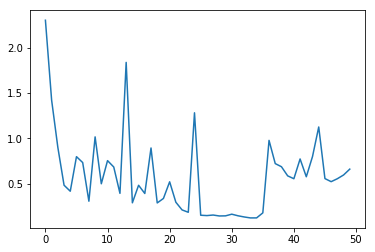

In [18]:
parametros1 = red_profunda(X_train, Y_train, X_test, Y_test, info_capas, learning_rate, num_iteraciones, batch_size, prob_perm) 